# TASK I

## Training of the model

In the first place, we download the data (if necessary) and load it.

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd '/content/gdrive/MyDrive/temp'
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.
del MOUNT_GOOGLE_DRIVE

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1W6_IjlSb9EZ5zhY8oIBmukQpbcGaB6hg/temp


In [ ]:
import os
if not os.path.exists('/content/gdrive/MyDrive/temp/data'):
  # downloading the data
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip

  # decompressing the data
  from zipfile import ZipFile

  with ZipFile('app_data_reduced.zip','r') as zip:
    zip.extractall()
    print('Data decompressed successfully')

  # removing the .zip file after extraction to clean space
  !rm app_data_reduced.zip

In [ ]:
# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100


print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


We now define the model we are using. It is a model called VGG19. We print the scheme of the model.

In the first place, data must be preprocessed to fill the needs of the model.


In [ ]:
print(np.max(X_train))
print(np.max(X_valid))

255
255


In [ ]:
# train set
if np.max(X_train) == 255:
  X_train = X_train.astype('float32')
  for i in range(0,X_train.shape[0]):
    x = X_train[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_train[i,] = tf.keras.applications.vgg19.preprocess_input(x)

# validation set
if np.max(X_valid) == 255:
  X_valid = X_valid.astype('float32')
  for i in range(0,X_valid.shape[0]):
    x = X_valid[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_valid[i,] = tf.keras.applications.vgg19.preprocess_input(x)

In [ ]:
print(np.max(X_train))
print(np.max(X_valid))

151.061
151.061


Now we load the base model. Note that we load it and set trainable = False, so that it's frozen.

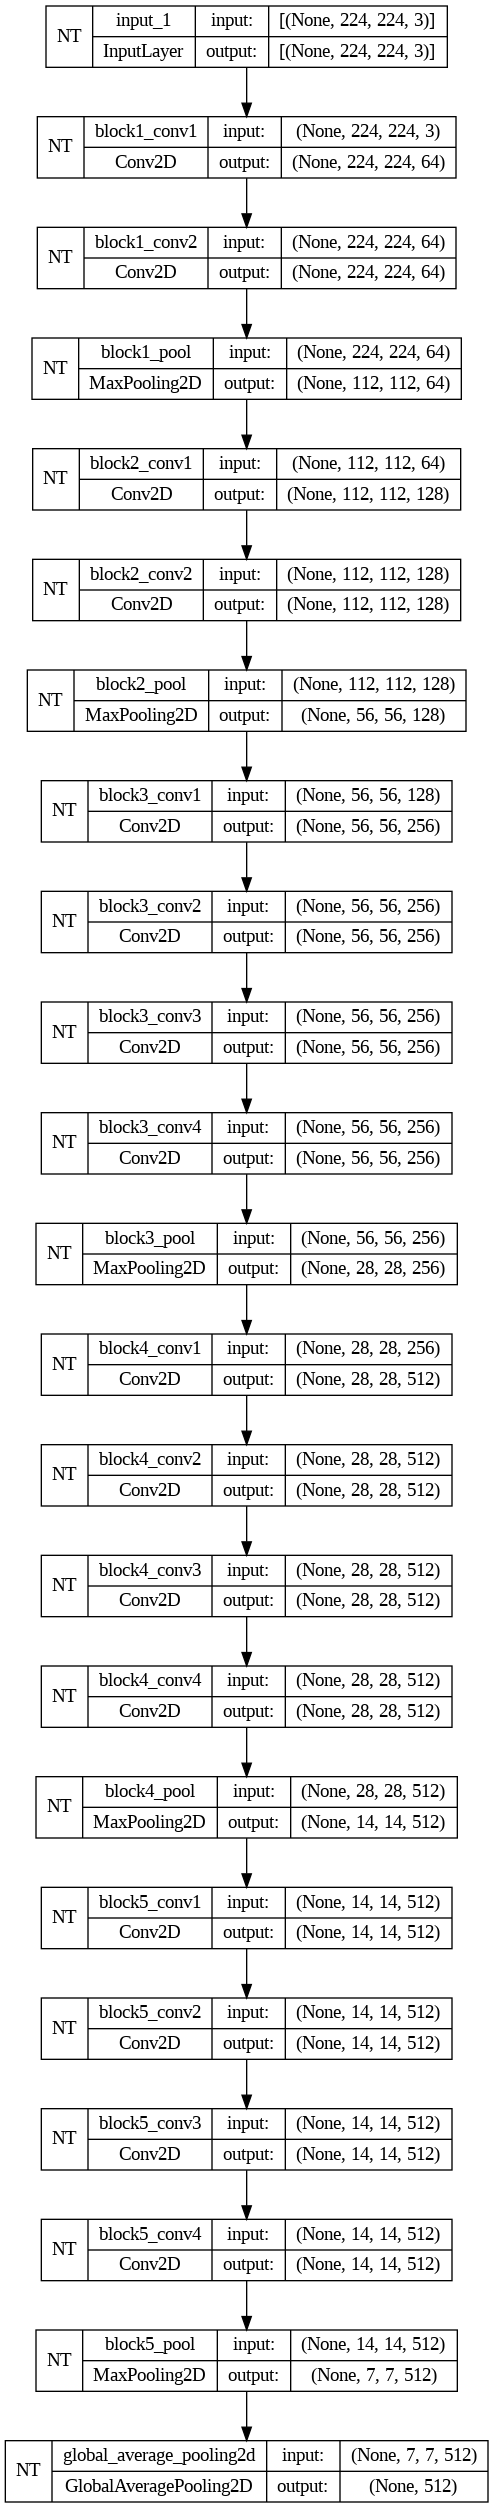

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Attention
from tensorflow.keras import regularizers
base_model = VGG19(weights='imagenet', include_top=False,pooling = 'avg',input_shape = (224,224,3))
# Freeze all layers in the base model
base_model.trainable = False

# Visualize the model
tf.keras.utils.plot_model(base_model, show_shapes=True,show_trainable=True)

To the base model, we add different fully connected layers with dropout layers in the middle to avoid overfitting.

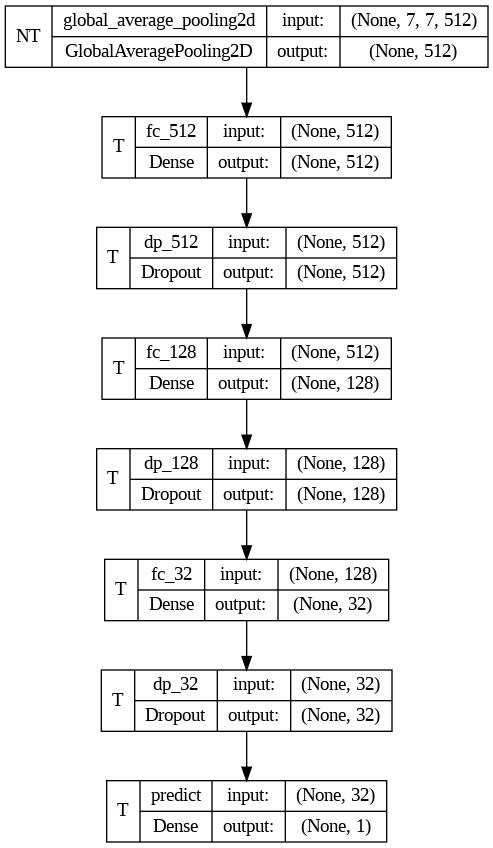

In [ ]:
import tensorflow as tf

dropout = 0.3

fc_2048 = base_model.get_layer(base_model.layers[-1].name).output

fc_512 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc_512')(fc_2048)
dp_layer_512 = tf.keras.layers.Dropout(dropout, name='dp_512')(fc_512)

fc_128 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc_128')(dp_layer_512)
dp_layer_128 = tf.keras.layers.Dropout(dropout, name='dp_128')(fc_128)

fc_32 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc_32')(dp_layer_128)
dp_layer_32 = tf.keras.layers.Dropout(dropout, name='dp_32')(fc_32)

output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(dp_layer_32)

# Building and printing the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
tf.keras.utils.plot_model(model, show_shapes=True,layer_range=[model.layers[-8].name,model.layers[-1].name],show_trainable = True)

We now train these fully connected layers, keeping the model frozen.

In [ ]:
TRAIN_ST1 = True
if TRAIN_ST1 == True:
  import pickle
  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  # saving the best model based on val_loss
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=70, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/70
89/89 [==============================] - ETA: 0s - loss: 7.0101 - mae: 0.2633

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 40s 336ms/step - loss: 7.0101 - mae: 0.2633 - val_loss: 6.2040 - val_mae: 0.1586
Epoch 2/70
89/89 [==============================] - 20s 223ms/step - loss: 5.5733 - mae: 0.1840 - val_loss: 4.9298 - val_mae: 0.1291
Epoch 3/70
89/89 [==============================] - 20s 230ms/step - loss: 4.4162 - mae: 0.1525 - val_loss: 3.9009 - val_mae: 0.1294
Epoch 4/70
89/89 [==============================] - 20s 227ms/step - loss: 3.4827 - mae: 0.1387 - val_loss: 3.0739 - val_mae: 0.1365
Epoch 5/70
89/89 [==============================] - 25s 288ms/step - loss: 2.7358 - mae: 0.1306 - val_loss: 2.4108 - val_mae: 0.1295
Epoch 6/70
89/89 [==============================] - 21s 236ms/step - loss: 2.1433 - mae: 0.1239 - val_loss: 1.8869 - val_mae: 0.1183
Epoch 7/70
89/89 [==============================] - 26s 291ms/step - loss: 1.6812 - mae: 0.1228 - val_loss: 1.4810 - val_mae: 0.1194
Epoch 8/70
89/89 [==============================] - 20s 227ms/step - loss: 1.319

Once the training is done, we visualize the results

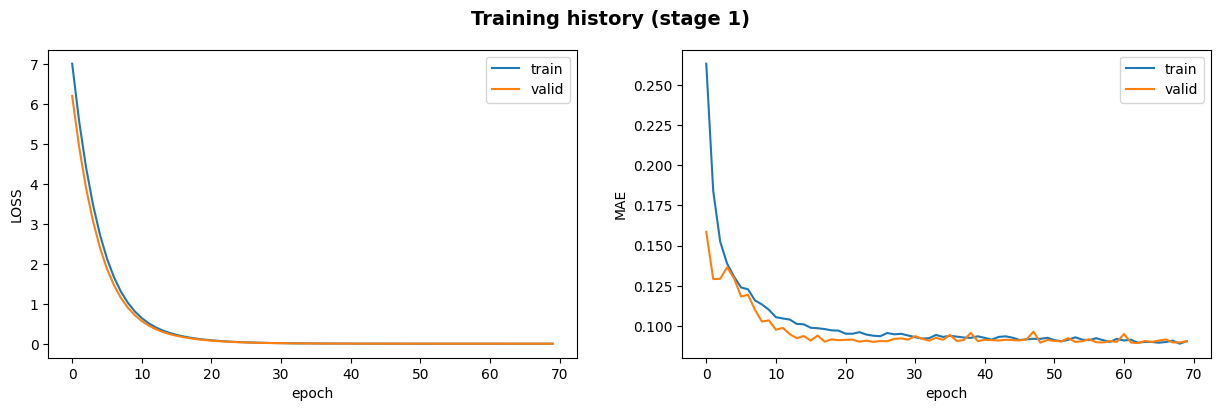

33/33 [==============================] - 5s 161ms/step
MAE (model stage 1, validation set) = 8.97013934


In [ ]:
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right');
plt.show()

model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5')
# predict on the validation data (normalized outputs)
predictions_st1_valid = model.predict(X_valid, batch_size=32, verbose=1)*100;
# evaluating on VALIDATION data (re-scalling predictions to the range of "ages", using the normalization factor)
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st1_valid[i][0],Y_valid[i]*100)))
print('MAE (model stage 1, validation set) = %.8f' %(np.mean(error)))

Now, we set the whole model as trainable, and train the whole model (stage 2 of training). We load the model of the 1st stage in case it isn't loaded.

In [ ]:
TRAIN_ST_2 = True
if TRAIN_ST_2 == True:
  import pickle
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5')

  model.trainable = True
  # training all layers (2nd stage), given the model saved on stage 1
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsoluteError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 0.0879 - mae: 0.0833

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 91s 404ms/step - loss: 0.0879 - mae: 0.0833 - val_loss: 0.0847 - val_mae: 0.0801
Epoch 2/50
178/178 [==============================] - 63s 352ms/step - loss: 0.0752 - mae: 0.0706 - val_loss: 0.0723 - val_mae: 0.0678
Epoch 3/50
178/178 [==============================] - 66s 369ms/step - loss: 0.0656 - mae: 0.0610 - val_loss: 0.0719 - val_mae: 0.0673
Epoch 4/50
178/178 [==============================] - 62s 347ms/step - loss: 0.0634 - mae: 0.0588 - val_loss: 0.0662 - val_mae: 0.0616
Epoch 5/50
178/178 [==============================] - 59s 331ms/step - loss: 0.0562 - mae: 0.0516 - val_loss: 0.0728 - val_mae: 0.0682
Epoch 6/50
178/178 [==============================] - 59s 329ms/step - loss: 0.0530 - mae: 0.0484 - val_loss: 0.0649 - val_mae: 0.0603
Epoch 7/50
178/178 [==============================] - 69s 390ms/step - loss: 0.0513 - mae: 0.0467 - val_loss: 0.0628 - val_mae: 0.0582
Epoch 8/50
178/178 [==============================] - 59s 334ms/st

Again, once finished, we visualize the results:

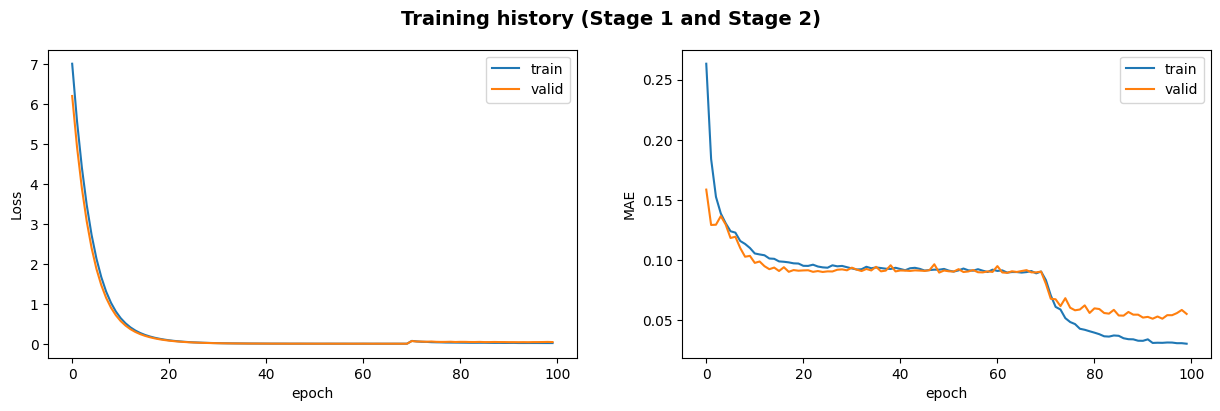

33/33 [==============================] - 13s 158ms/step
MAE (model stage 2, validation set) = 5.11538169


In [ ]:
import pickle
import matplotlib.pyplot as plt

train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))
train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

model_st2 = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5')
# predict on the validation data
predictions_st2_valid = model_st2.predict(X_valid, batch_size=32, verbose=1)*100
# evaluating on validation data (and re-scalling the predictions to the range of "ages")
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st2_valid[i][0],Y_valid[i]*100)))

print('MAE (model stage 2, validation set) = %.8f' %(np.mean(error)))

Also, see the biases of the errors:

In [ ]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# computing the age bias (model_stage_2)
age_bias(predictions_st2_valid,Y_valid*100)

# computing the gender bias (model_stage_2)
gender_bias(predictions_st2_valid,Y_valid*100,M_valid)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_st2_valid,Y_valid*100,M_valid)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_st2_valid,Y_valid*100,M_valid)


Age analysis:
Size group 1 = 205, MAE = 5.062734
Size group 2 = 590, MAE = 4.099959
Size group 3 = 197, MAE = 7.357284
Size group 4 = 45, MAE = 8.853982
---------
Age bias (Ba) =  2.759436289469401
Gender analysis:
Size group female = 497, MAE = 5.211228
Size group male = 540, MAE = 5.027167
---------
Gender bias (Bg) =  0.18406105
Ethnicity Analysis:
Size group asian = 79, MAE = 4.291794
Size group afroamerican = 32, MAE = 4.595777
Size group caucasian = 926, MAE = 5.203600
---------
Ethnicity bias (Be) =  0.6078707377115885
Face experession Analysis:
Size group happy = 298, MAE = 5.125025
Size group slightlyhappy = 311, MAE = 4.889430
Size group neutral = 351, MAE = 5.169587
Size group other = 77, MAE = 5.743583
---------
Face Expression bias (Bf) =  0.43450355529785156


We will try to improve this biases with data augmentation.

## Data Augmentation

In [ ]:
#Clean up the memory:
for var in dir():
      if not var.startswith('_'):
          exec(f'del {var}')
del var
import gc
gc.collect();

Initialize some flags to decide to load the data or to actually apply data augmentation

In [ ]:
APPLY_DATA_AUGMENTATION = False
SAVE_DATA_AUGMENTATION = False
N_min = 1
N_max= 5 #MAXIMUM NUMBER OF REPETITIONS OF EACH PICTURE IN DATA AUGMENTATION

We load the data depending on if the augmented data already exists or if we want to create it.

In [ ]:
import numpy as np
if APPLY_DATA_AUGMENTATION == False:
  # loading the train data (with labels)
  X_train = np.load('./data/data_train.npy')
  Y_train = np.load('./data/labels_train.npy')
  M_train = np.load('./data/meta_data_train.npy')

  # loading the validation data (with labels)
  X_valid = np.load('./data/data_valid.npy')
  Y_valid = np.load('./data/labels_valid.npy')
  M_valid = np.load('./data/meta_data_valid.npy')

  X_train_augmented = np.load('./data/X_train_augmented.npy')
  Y_train_augmented = np.load('./data/Y_train_augmented.npy')
  M_train_augmented = np.load('./data/M_train_augmented.npy')
  # train labels are real numbers, ranging from ~0.9 to ~89 (years old);
  # we will re-scale the labels to [0,1] by using a normalization factor of 100,
  # assuming there is no sample with age > 100.
  Y_train = Y_train/100
  Y_valid = Y_valid/100
  Y_train_augmented = Y_train_augmented/100

  print('Train data size and shape', X_train.shape)
  print('Train labels size and shape', Y_train.shape)
  print('Train metadata size and shape', M_train.shape)
  print('----')
  print('Valid data size and shape', X_valid.shape)
  print('Valid labels size and shape', Y_valid.shape)
  print('Valid metadata size and shape', M_valid.shape)
  print('----')
  print('Augmented train data size and shape', X_train_augmented.shape)
  print('Augmented train labels size and shape', Y_train_augmented.shape)
  print('Augmented train metadata size and shape', M_train_augmented.shape)
else:
  # loading the train data (with labels)
  X_train = np.load('./data/data_train.npy')
  Y_train = np.load('./data/labels_train.npy')
  M_train = np.load('./data/meta_data_train.npy')

  # loading the validation data (with labels)
  X_valid = np.load('./data/data_valid.npy')
  Y_valid = np.load('./data/labels_valid.npy')
  M_valid = np.load('./data/meta_data_valid.npy')

  # train labels are real numbers, ranging from ~0.9 to ~89 (years old);
  # we will re-scale the labels to [0,1] by using a normalization factor of 100,
  # assuming there is no sample with age > 100.
  Y_train = Y_train/100
  Y_valid = Y_valid/100


  print('Train data size and shape', X_train.shape)
  print('Train labels size and shape', Y_train.shape)
  print('Train metadata size and shape', M_train.shape)
  print('----')
  print('Valid data size and shape', X_valid.shape)
  print('Valid labels size and shape', Y_valid.shape)
  print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)
----
Augmented train data size and shape (4048, 224, 224, 3)
Augmented train labels size and shape (4048,)
Augmented train metadata size and shape (4048, 3)


In the cell below, a linear problem is being solved to create the augmented data. It returns a *repetitions* vector, which indicates the number of times each image has to appear in the augmented dataset (modified with procedures of data augmentation).

In [ ]:
if APPLY_DATA_AUGMENTATION:
  #Create vector for the linear problem
  M_train_mod = np.zeros((len(M_train[:,0]),13))
  M_train_mod[:,0] = M_train[:,0] == 'male'
  M_train_mod[:,1] = M_train[:,0] == 'female'
  M_train_mod[:,2] = M_train[:,1] == 'caucasian'
  M_train_mod[:,3] = M_train[:,1] == 'afroamerican'
  M_train_mod[:,4] = M_train[:,1] == 'asian'
  M_train_mod[:,5] = M_train[:,2] == 'happy'
  M_train_mod[:,6] = M_train[:,2] == 'slightlyhappy'
  M_train_mod[:,7] = M_train[:,2] == 'neutral'
  M_train_mod[:,8] = M_train[:,2] == 'other'
  M_train_mod[:,9] = Y_train < 0.2
  M_train_mod[:,10] = (Y_train >= 0.2) & (Y_train < 0.4)
  M_train_mod[:,11] = (Y_train >= 0.4) & (Y_train < 0.6)
  M_train_mod[:,12] = Y_train >= 0.6

  !pip install pulp

  #AND SOLVE THE PROBLEM:

  import numpy as np
  from pulp import *

  # Initialize the problem
  prob = LpProblem("Face_Balancing", LpMinimize)

  # Variables
  # x_i variables: number of times each sample is repeated (integer, between 1 and 10)
  x = LpVariable.dicts("repetition", range(2845), N_min, N_max, cat='Integer')

  total_representations = lpSum([x[i] for i in range(2845)])

  # Mean representations
  mean_gender = total_representations / 2  # 2 genders
  mean_ethnicity = total_representations / 3  # 3 ethnicities
  mean_emotion = total_representations / 4  # 4 emotions
  mean_age = total_representations / 4  # 4 age ranges

  # Auxiliary variables for linearizing absolute values
  d_gender = LpVariable.dicts("d_gender", range(2), lowBound=0)
  d_ethnicity = LpVariable.dicts("d_ethnicity", range(3), lowBound=0)
  d_emotion = LpVariable.dicts("d_emotion", range(4), lowBound=0)
  d_age = LpVariable.dicts("d_age", range(4), lowBound=0)


  # Gender Constraints
  for j in range(2):
    gender_imbalance = lpSum([x[i] * M_train_mod[i, j] for i in range(2845)]) - mean_gender
    prob += gender_imbalance <= d_gender[j]
    prob += -gender_imbalance <= d_gender[j]


  # Ethnicity Constraints
  for j in range(3):  # For each ethnicity
      ethnicity_imbalance = lpSum([x[i] * M_train_mod[i, j+2] for i in range(2845)]) - mean_ethnicity
      prob += ethnicity_imbalance <= d_ethnicity[j]
      prob += -ethnicity_imbalance <= d_ethnicity[j]


  # Emotion Constraints
  for k in range(4):
      emotion_imbalance = lpSum([x[i] * M_train_mod[i, k+5] for i in range(2845)]) - mean_emotion
      prob += emotion_imbalance <= d_emotion[k]
      prob += -emotion_imbalance <= d_emotion[k]


  for k in range(4):  # For each age
      age_imbalance = lpSum([x[i] * M_train_mod[i, k+9] for i in range(2845)]) - mean_age
      prob += age_imbalance <= d_age[k]
      prob += -age_imbalance <= d_age[k]


  # Adjusted Objective Function to minimize the maximum imbalance
  prob += lpSum(d_gender) + lpSum(d_ethnicity) + lpSum(d_emotion) + lpSum(d_age)

  # Solve the problem with a time limit
  time_limit_seconds = 60
  prob.solve(PULP_CBC_CMD(msg=True, timeLimit=time_limit_seconds))



  repetitions = [int(x[i].varValue) for i in range(2845)]
  print(max(repetitions))
  print(min(repetitions))
  print([[x,repetitions.count(x)] for x in set(repetitions)])


  keep_vars = ['repetitions','X_train','M_train','Y_train','X_valid','Y_valid','M_valid','APPLY_DATA_AUGMENTATION','DOWNLOAD_SET','MOUNT_GOOGLE_DRIVE','SAVE_DATA_AUGMENTATION','keep_vars']

  for var in dir():
      if var not in keep_vars and not var.startswith('_'):
          exec(f'del {var}')
  del keep_vars,var
  import gc
  gc.collect()

5
1
[[1, 2543], [3, 2], [4, 1], [5, 299]]


Now we design the algorithm which applies data augmentation to an image, given an image and an integer which indicates the times that the image has to be modified.

In [ ]:
#APPLY THE DATA AUGMENTATION REPETITION TIMES FOR EACH PICTURE
if APPLY_DATA_AUGMENTATION:
  import cv2
  import numpy as np
  #DEFINE THE FUNCTIONS TO APPLY DATA AUGMENTATION
  def x_symmetry(X):
      new_X = X[:, ::-1, :]
      return new_X

  def x_brightness(X):
      new_X = np.clip(0.7 * X + 0.3 * 255, 0, 255).astype(np.uint8)
      return new_X

  def x_darkness(X):
      new_X = np.clip(0.5 * X, 0, 255).astype(np.uint8)
      return new_X

  def apply_gaussian_blur(image, kernel_size=(7, 7), sigma=2):
      blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
      return np.clip(blurred_image, 0, 255).astype(np.uint8)

  def apply_sharpen(image):
      sharpening_filter = np.array([[-1, -1, -1],
                                    [-1, 9, -1],
                                    [-1, -1, -1]])
      sharpened_image = cv2.filter2D(image, -1, sharpening_filter)
      return np.clip(sharpened_image, 0, 255).astype(np.uint8)

  import numpy as np
  import random

  def Data_augmentation(X, y, meta, n):
      augmentations = {
          1: lambda img: img,
          2: x_brightness,
          3: x_darkness,
          4: apply_gaussian_blur,
          5: apply_sharpen,
          6: x_symmetry,
          7: lambda img: x_brightness(x_symmetry(img)),
          8: lambda img: x_darkness(x_symmetry(img)),
          9: lambda img: apply_gaussian_blur(x_symmetry(img)),
          10: lambda img: apply_sharpen(x_symmetry(img))
      }

      augmented = []
      augmented_y = []
      augmented_meta = []
      augmented_img = augmentations[1](X)
      augmented.append(augmented_img)
      augmented_y.append(y)
      augmented_meta.append(meta)
      if n > 1:
        # Randomly select n-1 unique augmentation numbers
        numbers = sorted(random.sample(range(2, 11), n-1))

        # Apply selected augmentations
        for i in numbers:
          augmented_img = augmentations[i](X)
          augmented.append(augmented_img)
          augmented_y.append(y)
          augmented_meta.append(meta)

      return np.array(augmented), np.array(augmented_y), np.array(augmented_meta)

  #APPLY DATA AUGMENTATION
    # Initialize lists to hold the augmented data
  X_train_augmented = []
  Y_train_augmented = []
  M_train_augmented = []

  # Loop through each sample in X_train
  for idx in range(len(X_train)):
      # Call Data_augmentation function for each image, with its label, metadata, and the number of augmentations specified by repetitions[idx]
      augmented_images, augmented_labels, augmented_metadata = Data_augmentation(X_train[idx], Y_train[idx], M_train[idx], repetitions[idx])

      # Extend the augmented dataset lists with the outputs from the Data_augmentation function
      X_train_augmented.extend(augmented_images)
      Y_train_augmented.extend(augmented_labels)
      M_train_augmented.extend(augmented_metadata)

  X_train_augmented = np.array(X_train_augmented)
  Y_train_augmented = np.array(Y_train_augmented)
  M_train_augmented = np.array(M_train_augmented)

  print("X_train_augmented shape:", X_train_augmented.shape)
  print("Y_train_augmented shape:", Y_train_augmented.shape)
  print("M_train_augmented shape:", M_train_augmented.shape)
  del augmented_images,augmented_labels,augmented_metadata,idx,repetitions
  if SAVE_DATA_AUGMENTATION:
    np.save('./data/X_train_augmented.npy', X_train_augmented)

    np.save('./data/Y_train_augmented.npy', Y_train_augmented*100)

    np.save('./data/M_train_augmented.npy', M_train_augmented)
del SAVE_DATA_AUGMENTATION

X_train_augmented shape: (4048, 224, 224, 3)
Y_train_augmented shape: (4048,)
M_train_augmented shape: (4048, 3)


Now we have the augmented set. Here is an example of the modifications applied to an image.

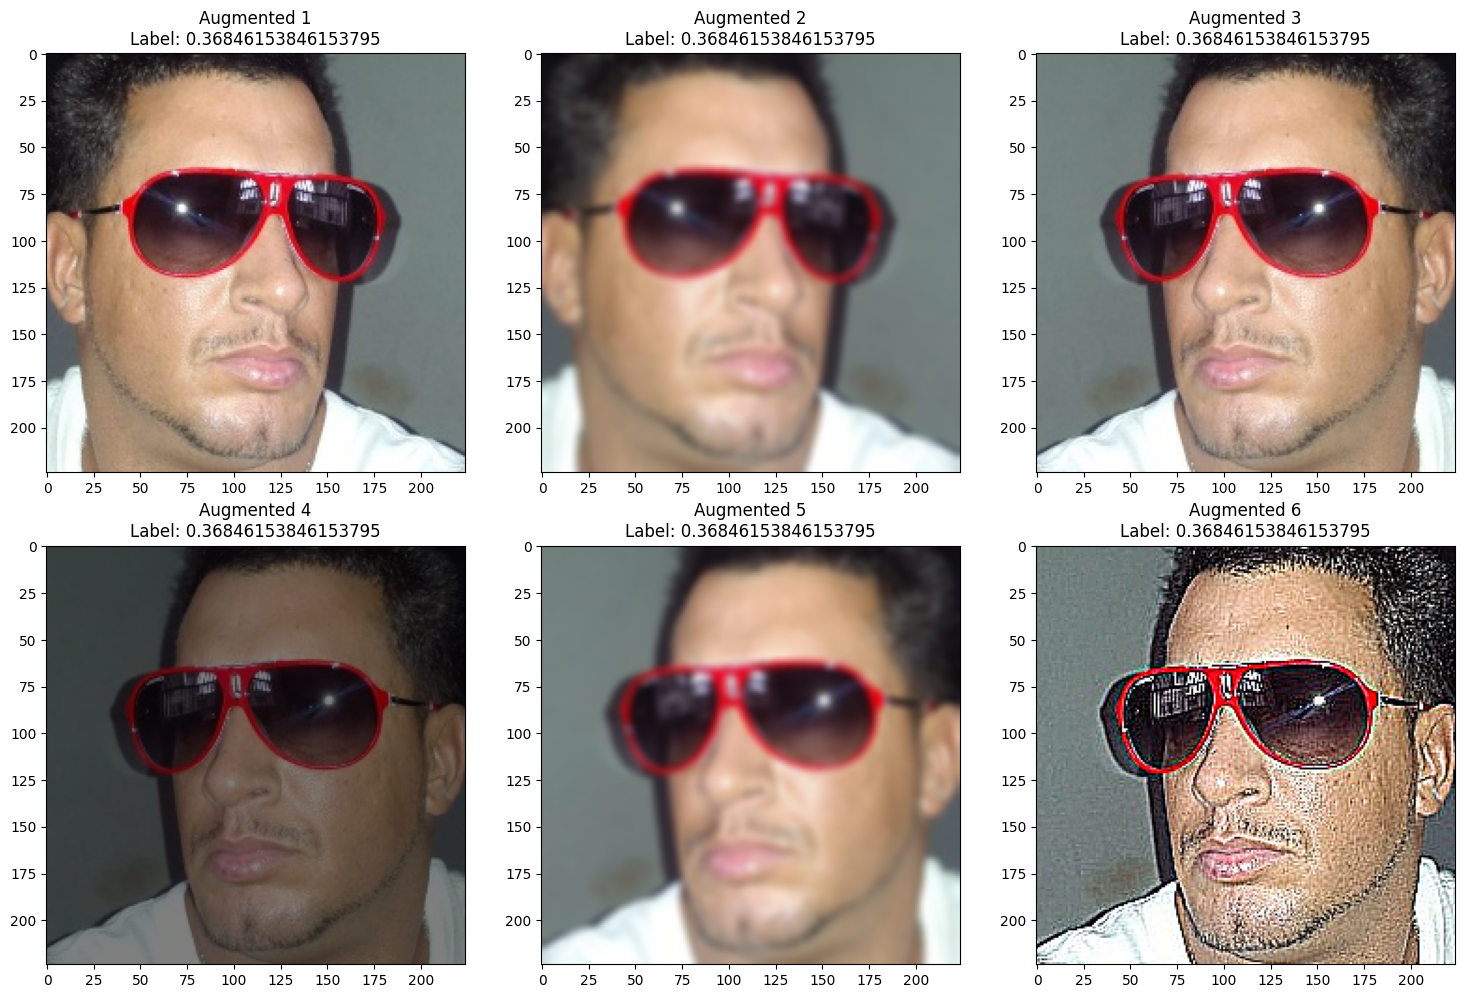

In [ ]:
#EXAMPLE OF DATA AUGMENTATION
SHOW_EXAMPLE = True
if SHOW_EXAMPLE and APPLY_DATA_AUGMENTATION:
  import matplotlib.pyplot as plt
  import cv2

  n = 6  # Example value for demonstration
  augmented_images, augmented_labels, augmented_metadata = Data_augmentation(X_train[0], Y_train[0], M_train[0], n)

  if n > 5:
      rows = 2
      cols = (n + 1) // 2
  else:
      rows = 1
      cols = n

  plt.figure(figsize=(15, 5 * rows))

  # Display the augmented images
  for i, img in enumerate(augmented_images):
      plt.subplot(rows, cols, i + 1)
      augmented_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(augmented_rgb)
      plt.title(f'Augmented {i+1}\nLabel: {augmented_labels[i]}')

  plt.tight_layout()
  plt.show()
  del augmented_images,augmented_labels,augmented_metadata,i,img,n,rows,augmented_rgb,cols
del SHOW_EXAMPLE,APPLY_DATA_AUGMENTATION

This is the results obtained balancing the data set:

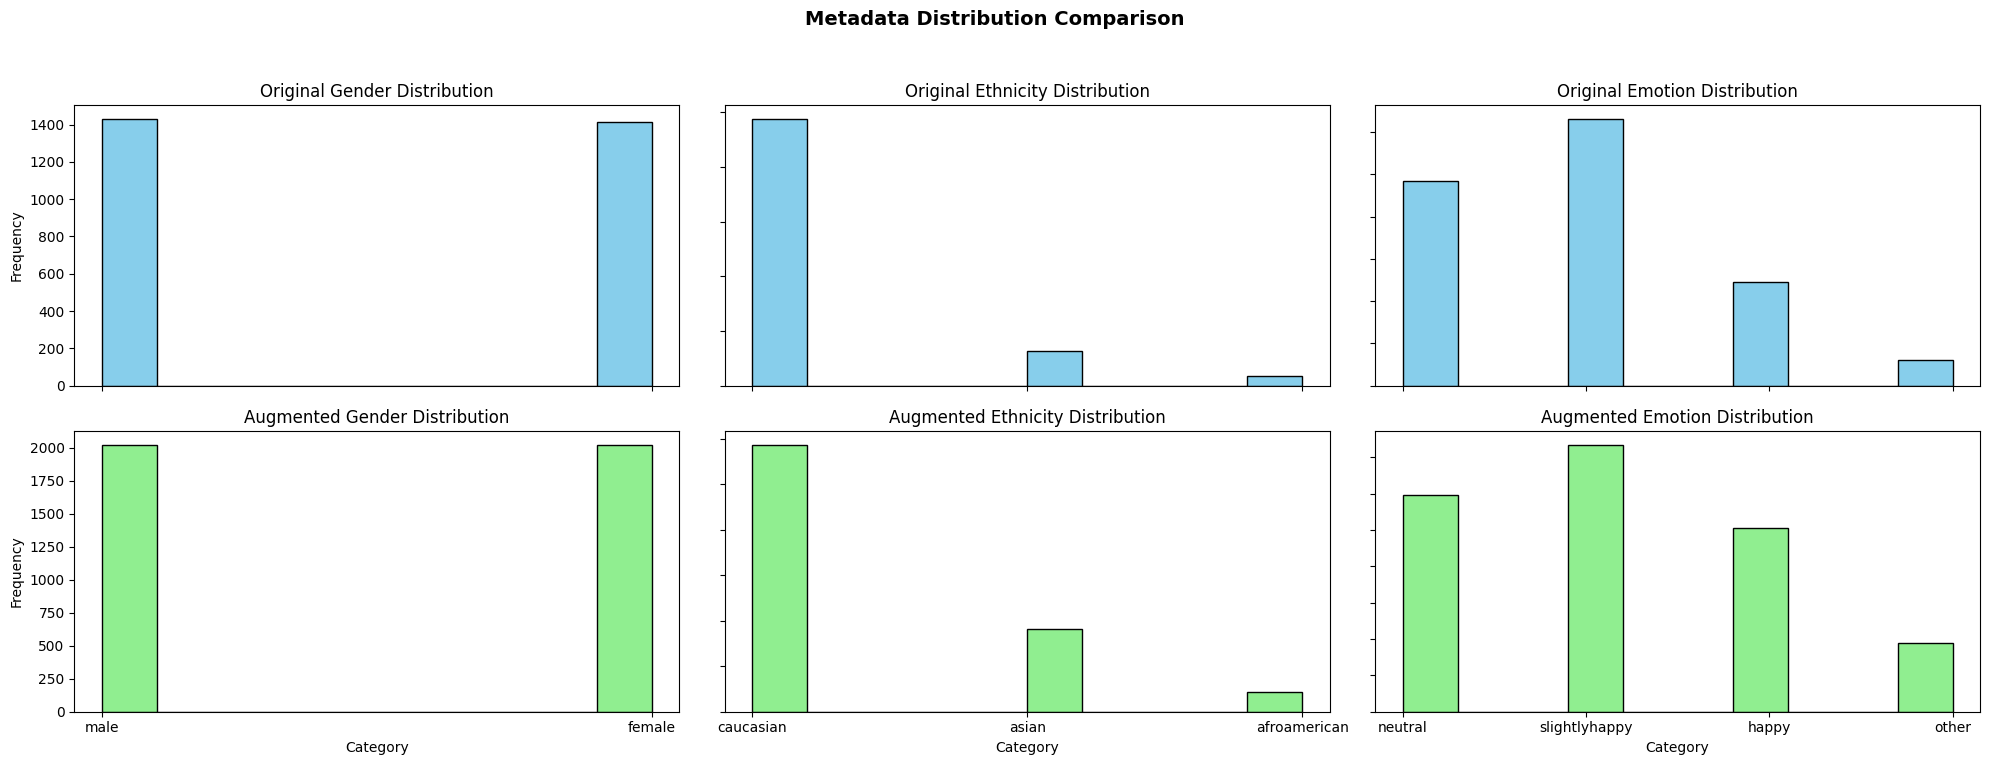

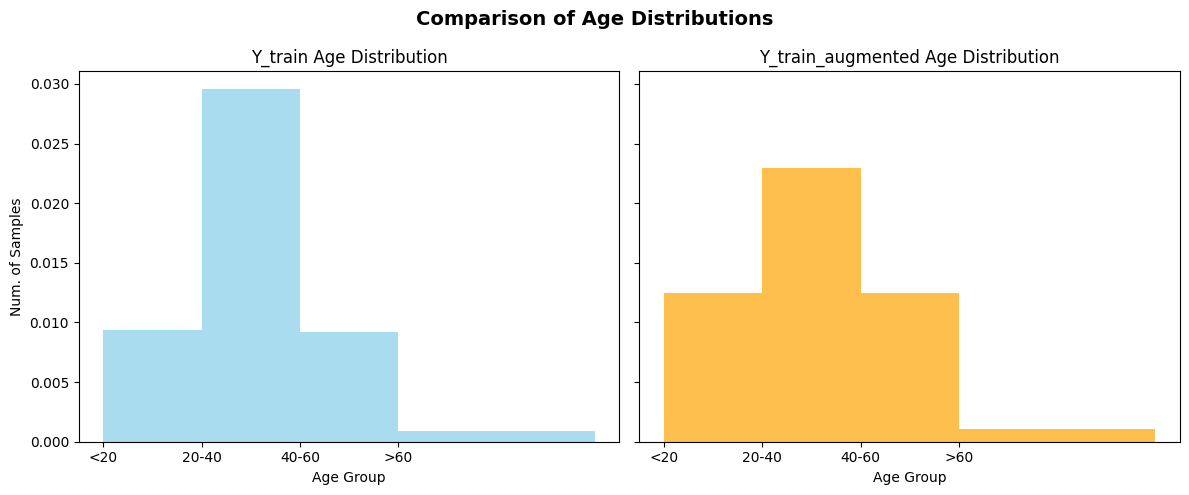

Original Gender Gini Coefficient: 0.0033
Augmented Gender Gini Coefficient: 0.0000

Original Ethnicity Gini Coefficient: 0.5509
Augmented Ethnicity Gini Coefficient: 0.4480

Original Emotion Gini Coefficient: 0.3430
Augmented Emotion Gini Coefficient: 0.2129

Original Age Gini Coefficient: 0.4173
Augmented Age Gini Coefficient: 0.3131


In [ ]:
# RESULTS OF THE BALANCING PROCESS
import matplotlib.pyplot as plt

# Original data extraction
gender = []
ethnicity = []
emotion = []
for sample in M_train:
    gender.append(sample[0])
    ethnicity.append(sample[1])
    emotion.append(sample[2])

# Augmented data extraction
gender_aug = []
ethnicity_aug = []
emotion_aug = []
for sample in M_train_augmented:
    gender_aug.append(sample[0])
    ethnicity_aug.append(sample[1])
    emotion_aug.append(sample[2])

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(20, 8))  # 2 rows for original and augmented, 3 columns for each category
fig.suptitle('Metadata Distribution Comparison', fontsize=14, fontweight='bold')

# Original data plots
axs[0, 0].hist(gender, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Original Gender Distribution')
axs[0, 1].hist(ethnicity, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Original Ethnicity Distribution')
axs[0, 2].hist(emotion, color='skyblue', edgecolor='black')
axs[0, 2].set_title('Original Emotion Distribution')

# Augmented data plots
axs[1, 0].hist(gender_aug, color='lightgreen', edgecolor='black')
axs[1, 0].set_title('Augmented Gender Distribution')
axs[1, 1].hist(ethnicity_aug, color='lightgreen', edgecolor='black')
axs[1, 1].set_title('Augmented Ethnicity Distribution')
axs[1, 2].hist(emotion_aug, color='lightgreen', edgecolor='black')
axs[1, 2].set_title('Augmented Emotion Distribution')

# Setting labels
for ax in axs.flat:
    ax.set(xlabel='Category', ylabel='Frequency')

for ax in axs.flat:
    ax.label_outer()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
del gender,gender_aug,emotion,emotion_aug,ethnicity,ethnicity_aug,ax,axs,fig,sample

import matplotlib.pyplot as plt

# Custom bins for the age groups
bins = [0, 20, 40, 60, 100]
bin_labels = ['<20', '20-40', '40-60', '>60']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Comparison of Age Distributions', fontsize=14, fontweight='bold')

# Histogram for Y_train
counts, _, _ = axes[0].hist(Y_train*100, bins=bins, color='skyblue', alpha=0.7,density=True)
axes[0].set_title('Y_train Age Distribution')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Num. of Samples')
axes[0].set_xticks(bins[:-1])
axes[0].set_xticklabels(bin_labels)

# Histogram for Y_train_augmented
counts_augmented, _, _ = axes[1].hist(Y_train_augmented*100, bins=bins, color='orange', alpha=0.7,density=True)
axes[1].set_title('Y_train_augmented Age Distribution')
axes[1].set_xlabel('Age Group')
axes[1].set_xticks(bins[:-1])
axes[1].set_xticklabels(bin_labels)

plt.tight_layout()
plt.show()
del bins,bin_labels,counts,counts_augmented,axes,fig


# Count occurrences of each category
gender_counts = np.array([np.sum(M_train[:, 0] == category) for category in np.unique(M_train[:, 0])])
ethnicity_counts = np.array([np.sum(M_train[:, 1] == category) for category in np.unique(M_train[:, 1])])
emotion_counts = np.array([np.sum(M_train[:, 2] == category) for category in np.unique(M_train[:, 2])])
bins = [0, 0.20, 0.40, 0.60, 1]  # Age bins
age_counts = np.histogram(Y_train, bins=bins)[0]  # Count samples in each age bin


gender_counts_aug = np.array([np.sum(M_train_augmented[:, 0] == category) for category in np.unique(M_train_augmented[:, 0])])
ethnicity_counts_aug = np.array([np.sum(M_train_augmented[:, 1] == category) for category in np.unique(M_train_augmented[:, 1])])
emotion_counts_aug = np.array([np.sum(M_train_augmented[:, 2] == category) for category in np.unique(M_train_augmented[:, 2])])
age_counts_aug = np.histogram(Y_train_augmented, bins=bins)[0]  # Count samples in each age bin


def gini_coefficient(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.astype(float)

    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 0.0000001

    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]


    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

gini_gender_aug = gini_coefficient(gender_counts_aug)
gini_ethnicity_aug = gini_coefficient(ethnicity_counts_aug)
gini_emotion_aug = gini_coefficient(emotion_counts_aug)
gini_age_aug = gini_coefficient(age_counts_aug)

gini_gender = gini_coefficient(gender_counts)
gini_ethnicity = gini_coefficient(ethnicity_counts)
gini_emotion = gini_coefficient(emotion_counts)
gini_age = gini_coefficient(age_counts)

print(f"Original Gender Gini Coefficient: {gini_gender:.4f}")
print(f"Augmented Gender Gini Coefficient: {gini_gender_aug:.4f}\n")

print(f"Original Ethnicity Gini Coefficient: {gini_ethnicity:.4f}")
print(f"Augmented Ethnicity Gini Coefficient: {gini_ethnicity_aug:.4f}\n")

print(f"Original Emotion Gini Coefficient: {gini_emotion:.4f}")
print(f"Augmented Emotion Gini Coefficient: {gini_emotion_aug:.4f}\n")

print(f"Original Age Gini Coefficient: {gini_age:.4f}")
print(f"Augmented Age Gini Coefficient: {gini_age_aug:.4f}")

del gender_counts, ethnicity_counts, emotion_counts, age_counts
del gender_counts_aug, ethnicity_counts_aug, emotion_counts_aug, age_counts_aug
del gini_gender, gini_ethnicity, gini_emotion, gini_age
del gini_gender_aug, gini_ethnicity_aug, gini_emotion_aug, gini_age_aug,bins

## Training with augmented data

Load the data and preprocess it

In [ ]:
# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

X_train_augmented = np.load('./data/X_train_augmented.npy')
Y_train_augmented = np.load('./data/Y_train_augmented.npy')
M_train_augmented = np.load('./data/M_train_augmented.npy')
# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_valid = Y_valid/100
Y_train_augmented = Y_train_augmented/100

print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Augmented train data size and shape', X_train_augmented.shape)
print('Augmented train labels size and shape', Y_train_augmented.shape)
print('Augmented train metadata size and shape', M_train_augmented.shape)

Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)
----
Augmented train data size and shape (4048, 224, 224, 3)
Augmented train labels size and shape (4048,)
Augmented train metadata size and shape (4048, 3)


In [ ]:
print(np.max(X_valid))
print(np.max(X_train_augmented))

255
255


In [ ]:
import tensorflow as tf
# validation set
if np.max(X_valid)==255:
  X_valid = X_valid.astype('float32')
  for i in range(0,X_valid.shape[0]):
    x = X_valid[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_valid[i,] = tf.keras.applications.vgg19.preprocess_input(x)

# Augmented train set
if np.max(X_train_augmented)==255:
  X_train_augmented = X_train_augmented.astype('float32')
  for i in range(0,X_train_augmented.shape[0]):
    x = X_train_augmented[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_train_augmented[i,] = tf.keras.applications.vgg19.preprocess_input(x)
  del x,i

In [ ]:
print(np.max(X_valid))
print(np.max(X_train_augmented))

151.061
151.061


Training process in stage 2 with augmented data

In [ ]:
TRAIN_ST2 = True
if TRAIN_ST2:
  import pickle
  # loading the saved model (best model learned at stage 1)
  saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5')

  # setting all layers to traineble
  saved_model.trainable = True

  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsoluteError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10)

  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train_augmented, Y_train_augmented, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage_augmentation.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
127/127 [==============================] - ETA: 0s - loss: 0.0900 - mae: 0.0853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 146s 930ms/step - loss: 0.0900 - mae: 0.0853 - val_loss: 0.0787 - val_mae: 0.0740
Epoch 2/50
127/127 [==============================] - 76s 601ms/step - loss: 0.0729 - mae: 0.0683 - val_loss: 0.0737 - val_mae: 0.0690
Epoch 3/50
127/127 [==============================] - 85s 667ms/step - loss: 0.0649 - mae: 0.0602 - val_loss: 0.0721 - val_mae: 0.0674
Epoch 4/50
127/127 [==============================] - 76s 595ms/step - loss: 0.0579 - mae: 0.0532 - val_loss: 0.0690 - val_mae: 0.0643
Epoch 5/50
127/127 [==============================] - 78s 613ms/step - loss: 0.0543 - mae: 0.0496 - val_loss: 0.0644 - val_mae: 0.0596
Epoch 6/50
127/127 [==============================] - 80s 628ms/step - loss: 0.0500 - mae: 0.0453 - val_loss: 0.0638 - val_mae: 0.0590
Epoch 7/50
127/127 [==============================] - 70s 550ms/step - loss: 0.0491 - mae: 0.0443 - val_loss: 0.0640 - val_mae: 0.0593
Epoch 8/50
127/127 [==============================] - 81s 638ms/s

We will add epochs until the early stopping callback is activated.

In [ ]:
TRAIN_ST2_LONG = True
if TRAIN_ST2_LONG:
  import pickle
  # loading the saved model (best model learned at stage 1)
  saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')

  # setting all layers to traineble
  saved_model.trainable = True

  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanAbsoluteError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10)

  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation_long.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train_augmented, Y_train_augmented, validation_data=(X_valid, Y_valid), batch_size=32, epochs=100, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage_augmentation_long.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/100
127/127 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.0275

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 122s 723ms/step - loss: 0.0308 - mae: 0.0275 - val_loss: 0.0531 - val_mae: 0.0499
Epoch 2/100
127/127 [==============================] - 71s 562ms/step - loss: 0.0304 - mae: 0.0271 - val_loss: 0.0515 - val_mae: 0.0483
Epoch 3/100
127/127 [==============================] - 68s 533ms/step - loss: 0.0308 - mae: 0.0276 - val_loss: 0.0536 - val_mae: 0.0504
Epoch 4/100
127/127 [==============================] - 67s 530ms/step - loss: 0.0302 - mae: 0.0270 - val_loss: 0.0524 - val_mae: 0.0492
Epoch 5/100
127/127 [==============================] - 68s 534ms/step - loss: 0.0296 - mae: 0.0264 - val_loss: 0.0553 - val_mae: 0.0521
Epoch 6/100
127/127 [==============================] - 68s 533ms/step - loss: 0.0295 - mae: 0.0263 - val_loss: 0.0533 - val_mae: 0.0502
Epoch 7/100
127/127 [==============================] - 67s 531ms/step - loss: 0.0295 - mae: 0.0264 - val_loss: 0.0520 - val_mae: 0.0489
Epoch 8/100
127/127 [==============================] - 67s 

Show the training history and MAE

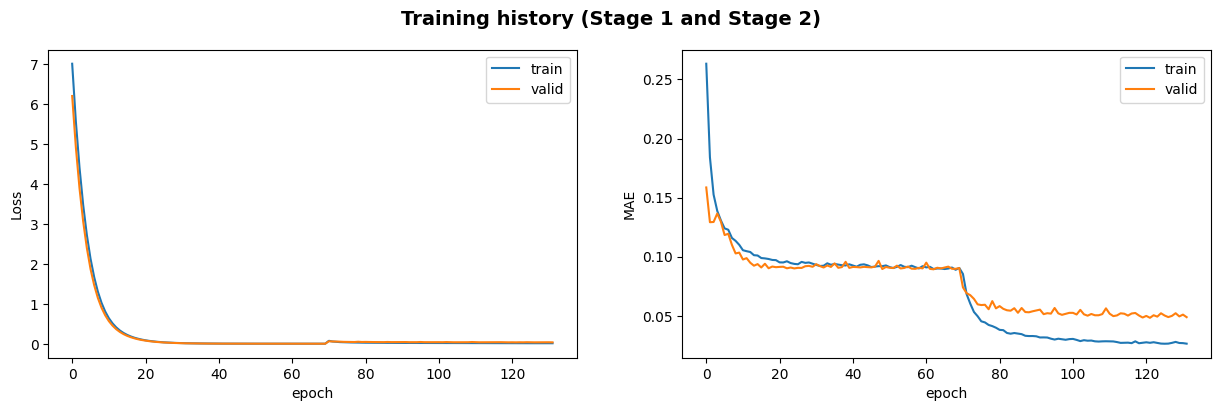

33/33 [==============================] - 5s 144ms/step
MAE (model stage 2, validation set) = 4.82509469


In [ ]:
import matplotlib.pyplot as plt
import pickle
train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage_augmentation.pkl","rb"))
train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))
train_hist_2nd_long = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage_augmentation_long.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss']+train_hist_2nd_long['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss']+train_hist_2nd_long['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae']+train_hist_2nd_long['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae']+train_hist_2nd_long['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

model_st2_augm = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation_long.h5')
predictions_st2_augmented = model_st2_augm.predict(X_valid, batch_size=32, verbose=1)*100
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st2_augmented[i][0],Y_valid[i]*100)))

print('MAE (model stage 2, validation set) = %.8f' %(np.mean(error)))

And finally the bias

In [ ]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# computing the age bias (model_stage_2)
age_bias(predictions_st2_augmented,Y_valid*100)

# computing the gender bias (model_stage_2)
gender_bias(predictions_st2_augmented,Y_valid*100,M_valid)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_st2_augmented,Y_valid*100,M_valid)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_st2_augmented,Y_valid*100,M_valid)


Age analysis:
Size group 1 = 205, MAE = 4.635492
Size group 2 = 590, MAE = 4.231721
Size group 3 = 197, MAE = 6.271513
Size group 4 = 45, MAE = 7.136529
---------
Age bias (Ba) =  1.7250741322835286
Gender analysis:
Size group female = 497, MAE = 4.808431
Size group male = 540, MAE = 4.840432
---------
Gender bias (Bg) =  0.03200102
Ethnicity Analysis:
Size group asian = 79, MAE = 4.632059
Size group afroamerican = 32, MAE = 4.566332
Size group caucasian = 926, MAE = 4.850506
---------
Ethnicity bias (Be) =  0.18944931030273438
Face experession Analysis:
Size group happy = 298, MAE = 5.030455
Size group slightlyhappy = 311, MAE = 4.401957
Size group neutral = 351, MAE = 4.850027
Size group other = 77, MAE = 5.625710
---------
Face Expression bias (Bf) =  0.6419482231140137


## Test predictions

In [ ]:
# loading the test data (with labels)
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')

#=================================================================
# post-processing the test data with respect to ResNet-50 Inputs.
#=================================================================
# test set
X_test = X_test.astype('float32')
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf.keras.applications.vgg19.preprocess_input(x)

print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)

----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)


In [ ]:
# making predictions on the TEST data (and re-scalling the predictions to the range of "ages")
model_st2_augm = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')
predictions_st2_test = model_st2_augm.predict(X_test, batch_size=32, verbose=1)*100

62/62 [==============================] - 9s 152ms/step


In [ ]:
# evaluating on test data
# note, the Y_test labels were not normalized, so they don't need to be re-scaled back
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st2_test[i][0],Y_test[i])))

print('MAE (model stage 2 (data augmentation), TEST set) = %.8f' %(np.mean(error)))

# printing some predictions
print('-----')
for i in range(0,10):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_test[i], Y_test[i]))

MAE (model stage 2 (data augmentation), TEST set) = 5.46721466
-----
predicted age = 24.943 - Ground truth = 23.205
predicted age = 58.035 - Ground truth = 70.737
predicted age = 43.909 - Ground truth = 55.368
predicted age = 24.912 - Ground truth = 24.278
predicted age = 24.755 - Ground truth = 25.231
predicted age = 45.434 - Ground truth = 35.179
predicted age = 17.194 - Ground truth = 26.923
predicted age = 43.321 - Ground truth = 48.189
predicted age = 16.344 - Ground truth = 18.676
predicted age = 42.313 - Ground truth = 57.378


<ipython-input-21-721f11611246>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_test[i], Y_test[i]))


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_test)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions_st2_augmented.zip predictions.csv

updating: predictions.csv (deflated 54%)
